# Part 1

In [ ]:
!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Step 4: Download the dataset
!kaggle datasets download -d pkdarabi/cardetection


 98% 95.0M/96.6M [00:00<00:00, 115MB/s]
100% 96.6M/96.6M [00:00<00:00, 117MB/s]


In [ ]:
!unzip cardetection.zip

The traffic sign image dataset comprises 4969 samples meticulously divided into three parts—Train, Valid, and Test. Featuring distinct classes such as Green Light, Red Light, Speed Limits ranging from 10 to 120, and Stop signs, the dataset presents a valuable resource for machine learning applications. With applications in autonomous vehicle navigation, the model derived from this dataset can empower self-driving cars to accurately recognize and respond to various traffic signs, ensuring adherence to traffic regulations. Additionally, the dataset finds utility in driver assistance systems, enhancing road safety by monitoring and alerting drivers who may violate speed limits or ignore red lights. Furthermore, it can serve as a foundation for road safety training programs, enabling simulations for new drivers to better understand and respond to different traffic scenarios. Beyond individual vehicles, the dataset can contribute to smart city initiatives, allowing authorities to employ the model in connected infrastructure for real-time monitoring of traffic compliance.

In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Dense, Flatten
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

# Define the directories
directories = ['/content/train', '/content/valid', '/content/test']

# Define the input shape
input_img = Input(shape=(64, 64, 3))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Flatten()(x)

# Decoder
x = Dense(units=8*8*8, activation='relu')(encoded)  # Reduced size
x = Reshape((8, 8, 8))(x)  # Adjusted to match the new size
x = UpSampling2D((8, 8))(x)  # Adjusted to match the new size
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder = Encoder + Decoder
autoencoder = Model(input_img, decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Prepare the image data generator
datagen = ImageDataGenerator(rescale=1./255)

# Train the model for each directory
for directory in directories[:-1]:  # Exclude the test directory
    print(f'Training for directory {directory} ...')

    train_data_gen = datagen.flow_from_directory(
        directory,
        target_size=(64, 64),
        batch_size=32,
        class_mode='input'  # The targets are images identical to input images
    )

    # Define the number of samples to use per epoch (this can be adjusted)
    samples_per_epoch = 1000

    # Fit data to model
    autoencoder.fit(train_data_gen, epochs=30, steps_per_epoch=samples_per_epoch // 32, verbose=1)


Training for directory /content/train ...
Found 3530 images belonging to 2 classes.
Epoch 1/30
31/31 [==============================] - 17s 519ms/step - loss: 0.7012
Epoch 2/30
31/31 [==============================] - 16s 516ms/step - loss: 0.6766
Epoch 3/30
31/31 [==============================] - 16s 510ms/step - loss: 0.6646
Epoch 4/30
31/31 [==============================] - 16s 508ms/step - loss: 0.6578
Epoch 5/30
31/31 [==============================] - 16s 515ms/step - loss: 0.6545
Epoch 6/30
31/31 [==============================] - 16s 515ms/step - loss: 0.6515
Epoch 7/30
31/31 [==============================] - 16s 511ms/step - loss: 0.6494
Epoch 8/30
31/31 [==============================] - 16s 503ms/step - loss: 0.6487
Epoch 9/30
31/31 [==============================] - 16s 508ms/step - loss: 0.6462
Epoch 10/30
31/31 [==============================] - 16s 507ms/step - loss: 0.6452
Epoch 11/30
31/31 [==============================] - 16s 513ms/step - loss: 0.6449
Epoch 12/30


31/31 [==============================] - 15s 474ms/step - loss: 0.6194


This code is for a Convolutional Autoencoder, a type of neural network used for unsupervised learning. It’s designed to process image data from specified directories, with the aim of learning a compressed representation of the input data and then reconstructing the original data as closely as possible. The model architecture includes an encoder (Conv2D and MaxPooling2D layers) that compresses the input, and a decoder (Dense, Reshape, UpSampling2D, and Conv2D layers) that reconstructs the input from the compressed representation. The model is trained using data from the ‘train’ and ‘valid’ directories, with the number of samples per epoch limited to reduce memory usage. The model’s performance can be evaluated by how well it reconstructs new, unseen data.

In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Dense
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Define the directories
directories = ['/content/train', '/content/valid', '/content/test']

# Define the input shape
input_img = Input(shape=(64, 64, 3))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Flatten()(x)

# Decoder
x = Dense(units=8*8*8, activation='relu')(encoded)  # Reduced size
x = Reshape((8, 8, 8))(x)  # Adjusted to match the new size
x = UpSampling2D((8, 8))(x)  # Adjusted to match the new size
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder = Encoder + Decoder
autoencoder = Model(input_img, decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Prepare the image data generator
datagen = ImageDataGenerator(rescale=1./255)

# Define a generator for the autoencoder
def autoencoder_generator(generator):
    for batch in generator:
        # Add random noise to the inputs
        noise_factor = 0.5
        batch_noisy = batch[0] + noise_factor * np.random.normal(loc=0., scale=1., size=batch[0].shape)
        batch_noisy = np.clip(batch_noisy, 0., 1.)
        # Yield (noisy input, original image) pairs
        yield batch_noisy, batch[0]

# Train the model for each directory
for directory in directories[:-1]:  # Exclude the test directory
    print(f'Training for directory {directory} ...')

    train_data_gen = datagen.flow_from_directory(
        directory,
        target_size=(64, 64),
        batch_size=32,
        class_mode='input'  # The targets are images identical to input images
    )

    train_data = autoencoder_generator(train_data_gen)

    # Define the number of samples to use per epoch (this can be adjusted)
    samples_per_epoch = 1000

    # Fit data to model
    autoencoder.fit(train_data, epochs=40, steps_per_epoch=samples_per_epoch // 32, verbose=1)


Training for directory /content/train ...
Found 3530 images belonging to 2 classes.
Epoch 1/40
31/31 [==============================] - 18s 539ms/step - loss: 0.7236
Epoch 2/40
31/31 [==============================] - 17s 563ms/step - loss: 0.6841
Epoch 3/40
31/31 [==============================] - 17s 537ms/step - loss: 0.6809
Epoch 4/40
31/31 [==============================] - 19s 598ms/step - loss: 0.6788
Epoch 5/40
31/31 [==============================] - 16s 528ms/step - loss: 0.6773
Epoch 6/40
31/31 [==============================] - 16s 527ms/step - loss: 0.6762
Epoch 7/40
31/31 [==============================] - 17s 544ms/step - loss: 0.6758
Epoch 8/40
31/31 [==============================] - 16s 524ms/step - loss: 0.6749
Epoch 9/40
31/31 [==============================] - 17s 553ms/step - loss: 0.6745
Epoch 10/40
31/31 [==============================] - 17s 532ms/step - loss: 0.6738
Epoch 11/40
31/31 [==============================] - 23s 766ms/step - loss: 0.6747
Epoch 12/40


This code creates a denoising Convolutional Autoencoder, a type of neural network used for unsupervised learning to remove noise from images. The model is designed to process image data from specified directories, learn a compressed representation of the input data, and then reconstruct the original data as closely as possible from the noisy inputs. The architecture includes an encoder that compresses the input, and a decoder that reconstructs the input from the compressed representation. The model is trained using data from the ‘train’ and ‘valid’ directories, with the number of samples per epoch limited to reduce memory usage. The performance of the model can be evaluated by how well it reconstructs new, unseen data from noisy inputs.

# part 2

In [ ]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Flatten, Reshape
from keras.layers import Conv2D, UpSampling2D
from keras.optimizers import Adam
from tqdm import tqdm

# Load CIFAR-10 data
(X_train, _), (_, _) = cifar10.load_data()

# Normalize data
X_train = X_train / 255.0

# Define the generator model
generator = Sequential()
generator.add(Dense(256*8*8, activation='relu', input_dim=100))
generator.add(Reshape((8, 8, 256)))
generator.add(UpSampling2D())
generator.add(Conv2D(256, kernel_size=3, padding='same', activation='relu'))
generator.add(UpSampling2D())
generator.add(Conv2D(256, kernel_size=3, padding='same', activation='relu'))
generator.add(Conv2D(3, kernel_size=3, padding='same', activation='sigmoid'))

# Define the discriminator model
discriminator = Sequential()
discriminator.add(Conv2D(256, kernel_size=3, strides=2, padding='same', activation='relu', input_shape=(32, 32, 3)))
discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding='same', activation='relu'))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))

# Compile the discriminator
discriminator.compile(loss='binary_crossentropy', optimizer=Adam())

# Create the GAN model
discriminator.trainable = False
gan = Sequential([generator, discriminator])

# Compile the GAN model
gan.compile(loss='binary_crossentropy', optimizer=Adam())

# Train the GAN
batch_size = 32
steps_per_epoch = int(2 * X_train.shape[0] / batch_size)

for epoch in range(10):
    for step in tqdm(range(steps_per_epoch), desc="Steps"):
        # Generate random noise
        noise = np.random.normal(0, 1, (batch_size, 100))
        # Generate fake images
        fake_images = generator.predict(noise)
        # Get random real images
        real_images = X_train[np.random.randint(0, X_train.shape[0], batch_size)]
        # Combine real and fake images
        X = np.concatenate([real_images, fake_images])
        # Create labels
        y = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
        # Train the discriminator
        discriminator_loss = discriminator.train_on_batch(X, y)
        # Train the generator
        y = np.ones((batch_size, 1))
        noise = np.random.normal(0, 1, (batch_size, 100))
        generator_loss = gan.train_on_batch(noise, y)

Steps: 100%|██████████| 3125/3125 [06:45<00:00,  7.71it/s]



This code implements a Generative Adversarial Network (GAN) using the Keras library with TensorFlow backend for training on the CIFAR-10 dataset. The GAN consists of a generator and a discriminator. The generator aims to create realistic images, while the discriminator aims to distinguish between real and generated images. The generator and discriminator models are trained simultaneously in an adversarial manner. The generator generates fake images from random noise, and the discriminator is trained to distinguish between real and fake images. The discriminator is then combined with the generator to form the GAN model. The training loop runs for ten epochs, iterating through batches of real and generated images, updating the discriminator and generator weights to improve their performance. The tqdm library is used to display a progress bar during training.

# part 3

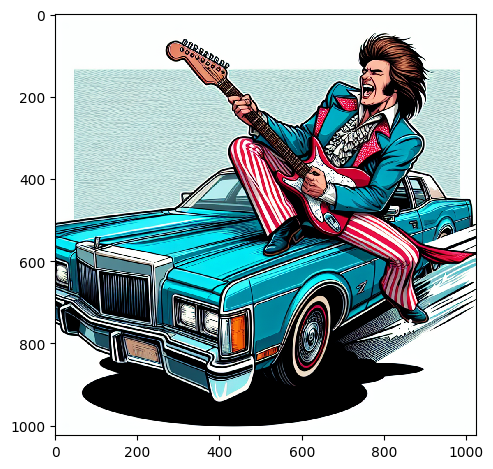

In [19]:
import os
from gtts import gTTS
from openai import OpenAI
import requests
from skimage import io

client = OpenAI(api_key='sk-XXXXXXX')

response = client.images.generate(
  model="dall-e-3",
  prompt="A blue 70s Lincoln Continental Mark V driven by Eddie van Halen singing Panama in a comic book art style",
  size="1024x1024",
  quality="standard",
  n=1,
)

image_url = response.data[0].url

# Download image
image_data = requests.get(image_url).content
with open('Eddie.png', 'wb') as handler:
    handler.write(image_data)

img = io.imread("Eddie.png")
io.imshow(img)

In [37]:
import os
from gtts import gTTS
from openai import OpenAI
import requests
from skimage import io

client = OpenAI(api_key='sk-XXXXXXX')

# Generate text
prompt = "Write a 2 paragraph story about Eddie van Halen saving the world singina Panama while driving a blue 70s Lincoln Continental Mark V"
response = client.completions.create(
  model="gpt-3.5-turbo-instruct",
  prompt=prompt,
  max_tokens=2000,
  n=1,
  stop=None,
)
story = response.choices[0].text
print(story)

# Text-to-speech
tts = gTTS(text=story)
tts.save("story.mp3")



Eddie van Halen, the renowned rockstar, was driving his beloved blue 70s Lincoln Continental Mark V down the streets of Panama. As the familiar melody of his hit song "Panama" blared through the speakers, he couldn't help but feel a sense of nostalgia. Suddenly, a loud explosion shattered the peaceful drive and Eddie realized that the world was in danger.

Without hesitation, he stepped on the gas pedal and raced towards the source of the explosion. As he arrived at the scene, he saw a group of villains trying to activate a destructive weapon. Without thinking twice, Eddie grabbed his guitar and started playing a powerful solo, channeling all his energy into it. The sound waves from his guitar were so intense that it neutralized the weapon and saved the world from destruction. As the crowd cheered and thanked him, Eddie couldn't help but think that his trusty blue Lincoln had truly been a hero in this epic adventure. 


This code does two main things. First, it uses the OpenAI API to generate an image based on a given prompt, downloads the image, and displays it. The image is generated using the DALL-E model with the prompt “A blue 70s Lincoln Continental Mark V driven by Eddie van Halen singing Panama in a comic book art style”. The generated image is then downloaded and saved as ‘Eddie.png’, and finally displayed using the skimage library. Second, the code generates a two-paragraph story about Eddie van Halen saving the world while singing Panama and driving a blue 70s Lincoln Continental Mark V, using the GPT-3.5 Turbo model. The generated story is then converted into speech using the Google Text-to-Speech (gTTS) library and saved as an mp3 file named ‘story.mp3’. This allows the story to be played back as audio.

# part 6

Adversarial learning is a machine learning approach that involves training two neural networks, a generator, and a discriminator, in a competitive or adversarial manner. The generator creates synthetic data, and the discriminator aims to distinguish between real and generated data. The two networks are trained iteratively, with the generator improving its ability to create realistic data to deceive the discriminator, and the discriminator improving its ability to differentiate between real and generated data. This adversarial process continues until the generator produces data that is indistinguishable from real data. Adversarial learning is commonly used in Generative Adversarial Networks (GANs) for tasks such as image and text generation.

# part 7

Epoch 1/30
469/469 [==============================] - 89s 183ms/step - loss: 323.7574 - reconstruction_loss: 318.6969 - kl_loss: 5.0605
Epoch 2/30
469/469 [==============================] - 95s 201ms/step - loss: 279.7122 - reconstruction_loss: 274.9902 - kl_loss: 4.7219
Epoch 3/30
469/469 [==============================] - 86s 184ms/step - loss: 272.5935 - reconstruction_loss: 268.3254 - kl_loss: 4.2680
Epoch 4/30
469/469 [==============================] - 86s 183ms/step - loss: 269.6243 - reconstruction_loss: 265.6254 - kl_loss: 3.9989
Epoch 5/30
469/469 [==============================] - 87s 185ms/step - loss: 267.4738 - reconstruction_loss: 263.6480 - kl_loss: 3.8257
Epoch 6/30
469/469 [==============================] - 88s 188ms/step - loss: 266.2222 - reconstruction_loss: 262.4236 - kl_loss: 3.7986
Epoch 7/30
469/469 [==============================] - 92s 197ms/step - loss: 265.1368 - reconstruction_loss: 261.3057 - kl_loss: 3.8311
Epoch 8/30
469/469 [============================

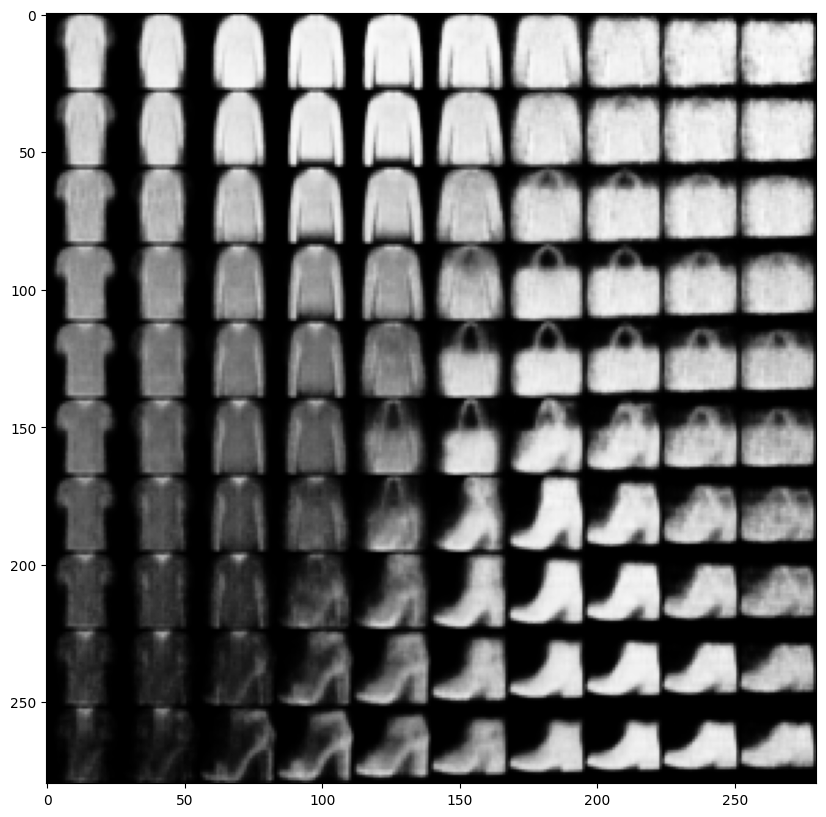

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import fashion_mnist

# Load the Fashion MNIST dataset
(x_train, _), (x_test, _) = fashion_mnist.load_data()

# Normalize the data to the range of [0., 1.]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Add a channel dimension
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Define the encoder
latent_dim = 2
encoder_inputs = layers.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var])

# Define the decoder
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = tf.keras.Model(latent_inputs, decoder_outputs)

# Define the VAE as a Model with a custom train_step
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = z_mean + tf.exp(0.5 * z_log_var) * tf.random.normal(shape=(latent_dim,))
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

# Train the VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())
vae.fit(x_train, epochs=30, batch_size=128)

# Generate new images
n = 10  # Number of images to generate
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()



This code implements a Variational Autoencoder (VAE) using TensorFlow and Keras for image generation and manipulation. It uses the Fashion MNIST dataset and comprises three main parts: data preprocessing, defining the encoder and decoder networks, and training the VAE. The encoder takes an input image and produces two vectors, representing the mean and log variance of a latent space. The decoder then reconstructs the input image from a sample in this latent space. The VAE is trained using a custom training step that combines a reconstruction loss and a KL divergence loss, encouraging the model to learn a meaningful and continuous latent space. After training, the VAE is used to generate new images by sampling from the latent space and decoding the samples. The generated images are visualized in a grid.